# Analysis of User Reviews from Rotten Tomatoes Pt. 1/2

In my notebooks titled `tomatoes_host_user` and `tomatoes_parasite_user`, I went through the Rotten Tomatoes website (site that contains movie reviews) and scraped user reviews of [_The Host_](https://www.rottentomatoes.com/m/the_host_2007) and [_Parasite_](https://www.rottentomatoes.com/m/parasite_2019), respectively. After scraping, cleaning, and organizing the user review data for both movies, I wrote them out as JSON files so that I can run my series of analyses on the data! 

In this notebook, similar to the steps I went through in the notebook called `analysis_user_metacritic`, I will be going through user review data of both movies, and again, the overall question I'm trying to answer is: **Was _Parasite_ more well-received (higher percentage of positively rated reviews, higher sentiment scores throughout reviews) than _The Host_**? 

I will split up my analysis into 5 parts, and only parts 1-2 are in this notebook. Analyses 3-5 are in the next notebook titled `analysis_user_tomatoes2`. Here is the full list of my analyses:
1. Looking at positively, neutrally, and negatively rated reviews of each movie 
2. Keyness analysis & KWIC concordance analysis for pos and neg reviews
3. Using VADER to run sentiment analysis round 1
4. Using the NRC VAD Lexicon for sentiment analysis round 2
5. Using the NRC Emotion Lexicon for sentiment analysis round 3

Therefore, the bulk of my project and what will help me answer my overall research question, relies on **sentiment analysis!** I'm very excited to see what results we'll end up with, and how we can better understand the public audience sentiment of both movies!

Now, before we dive into my analyses, let's run some set-up cells:

In [1]:
import json
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

In [2]:
chars_to_remove = '.,!?/()'
random.seed(0)

In [3]:
%run functions.ipynb

## Analysis pt. 1: Splitting into positive and negative ratings, Keyness Analysis

### Is there a higher percentage of positively rated reviews of _Parasite_ than that of _The Host_ ?

### Looking at user reviews of _The Host_ :

I'm going to load in the text data of these user reviews from Rotten Tomatoes (RT), look at how many reviews I have, and then run some analyses, including dividing the reviews by score (which was given on a five-star range, so scores run from 0 to 5) and also sentiment analysis.

In [4]:
# Loading in the text data:
rt_host_user = json.load(open('../data/user_reviews/tomatoes_host_user.json'))

Let's see what the data structure looks like, and also how many user reviews we have of _The Host_

In [5]:
# First review in the list, to look at the structure:
rt_host_user[0]

{'date': 'Dec 30, 2009',
 'score': 3.5,
 'text': 'For a monster movie this was quite good. Decent special effects and good acting all around. I feel that the aspect of military involvement and the supposed virus scare was never really expanded upon properly, leaving lots of "why?" when the credits role. Overall a great overseas horror flick, and I gotta say it\'s good to see something from that part of te globe where te main antagonist is NOT a woman with long black hair hanging in front of her face :)'}

In [6]:
# How many user reviews of The Host in my data:
len(rt_host_user)

4855

So we have a list of dictionaries, in which each dictionary (each unit) represents a user review that was posted on RT. The information I've pulled from the RT site is the date of the review, the score that the reviewer gave (on a scale of 0-5, or out of 5 stars), and the text of the review. We are working with 4,855 user reviews here! That's a pretty good amount to carry out some textual analysis on. 

For the first part of this user review analysis, I want to split the reviews into positive, negative, and neutral scores. So I'll make three separate lists, one with all the positive reviews (those with a score rating greater than or equal to 4 stars), one with all the negative reviews (those with a score rating lower than 3), and lump together everything in between into a list of neutral reviews (scores between 3 and 4).

In [7]:
# Splitting into positive and negative user reviews:

pos_host = []
neg_host = []
neu_host = []

for review in rt_host_user:
    if review['score']>=4:
        pos_host.append(review)
    elif review['score']<3:
        neg_host.append(review)
    else:
        neu_host.append(review)

In [8]:
# How many reviews scored the movie higher than 3 stars:
len(pos_host)

2385

In [9]:
# How many reviews scored the movie lower than 3 stars:
len(neg_host)

852

In [10]:
len(neu_host)

1618

In [11]:
# Percentage of positive reviews:
(len(pos_host) / len(rt_host_user)) * 100

49.12461380020597

In [12]:
# Percentage of negative and neutral reviews:
((len(neg_host) + len(neu_host)) / len(rt_host_user)) * 100

50.87538619979403

### Observations

* This is pretty fascinating! Based on the initial analysis, it looks like the reviews are split pretty evenly between positively scored reviews (represents about 49.1% of the reviews) and negatively or neutrally scored ones (about 50.9% of the reviews), with a little more negative than positive scored reviews!
* Although this does not tell us exactly what kinds of language the audience is using to rate _The Host_ on RT, we do know that quantitatively, the ratings are divided. It's not particularly leaning towards user reviews being completely negative or positive. 
* But it is important to note that overall, there is a slightly higher percentage of negatively or neutrally scored reviews than positively scores reviews.

We can take a look at some of the positive and negative reviews, just to get a sample of what user reviews say about the movie:

In [13]:
# Looking at some of the negative user reviews:
neg_host[:5]

[{'date': 'Dec 15, 2009',
  'score': 2.5,
  'text': "It wasn't really as thrilling as I expected it to be, and some of the character's stupidity/lack of will was frustrating. That said, it's not a bad movie. Definitely watchable."},
 {'date': 'Dec 01, 2009',
  'score': 1.5,
  'text': 'Did not like!   They did make a really good monster though, but the movie sucked.'},
 {'date': 'Nov 26, 2009',
  'score': 2,
  'text': 'Not as good as i had hoped. I always like to see how the americans are portrayed in asian films--bossy, know-it-all fools, mostly, and the host is no exception.'},
 {'date': 'Nov 04, 2009',
  'score': 2,
  'text': "People here like it. I don't know why. The creature is good, the idea is good, even the intentions of the writers were probably good, but the comic relief parts were painfully unpleasant, the story makes no sense, and some of the actors should have taken lessons, or died trying."},
 {'date': 'Oct 26, 2009',
  'score': 2,
  'text': 'please end...oh god, when wil

In [14]:
# Looking at the first five positive user reviews:
pos_host[:5]

[{'date': 'Dec 25, 2009',
  'score': 4,
  'text': 'I liked this a lot more than Cloverfield. Great cinematography on top of a fun action packed monster drama. South Korea knocks it out of the park again.'},
 {'date': 'Dec 25, 2009',
  'score': 5,
  'text': "I watched this film again recently. It's probably my fourth or fifth time and I still enjoyed it. I think I can watch this film over and over and over again and never get sick of it. One of the best monster movies ever."},
 {'date': 'Dec 22, 2009',
  'score': 4.5,
  'text': "I hadn't seen it since in the theater and I picked up the Blu.  Its still amazing.  There's a lot of interesting social commentary underneath this ridiculously entertaining monster movie, but it successfully never goes overboard.  At the heart of it all is a really awesome, fully realized family.  The part when they're reintroduced as they're mourning the daughter's false death is classic.  See it, if you haven't already.  And if so, see it again."},
 {'date': '

### Looking at user reviews of _Parasite_ :

Now I'm going to carry out the same steps as above, but this time for user reviews of _Parasite_ . I'm going to load in the data, split into positive, negative, and neutral reviews based on the review scores, and make some observations, before going into the bulk of my project, which is carrying out sentiment analysis on the review data.

In [15]:
# Load in the data:
rt_parasite_user = json.load(open('../data/user_reviews/tomatoes_parasite_user.json'))

In [16]:
# Look at the first item in the list:
rt_parasite_user[0]

{'date': 'May 1, 2021',
 'score': 5,
 'text': "Watch it!!!!!!! I don't need to say a word, just trust me."}

In [17]:
# Number of user reviews of Parasite in my data:
len(rt_parasite_user)

4409

The list of dictionaries is in the same structure and has the same three categories of information: `date`, `score`, and `text` of the review. And we have 4,409 user reviews of _Parasite_ so now let's take a look at dividing them into positively rated, negatively rated, and neutral ones!

In [18]:
# Splitting into positive and negative user reviews:

pos_parasite = []
neg_parasite = []
neu_parasite = []

for review in rt_parasite_user:
    if review['score']>=4:
        pos_parasite.append(review)
    elif review['score']<3:
        neg_parasite.append(review)
    else:
        neu_parasite.append(review)

In [19]:
# Number of positively rated reviews of Parasite: 
len(pos_parasite)

3503

In [20]:
# Number of negatively rated reviews of Parasite:
len(neg_parasite)

538

In [21]:
# Number of neutral reviews (scores between 3-4):
len(neu_parasite)

368

In [22]:
# Percent of positively rated reviews:
(len(pos_parasite) / len(rt_parasite_user)) * 100

79.4511227035609

In [23]:
# Percent of negatively or neutrally rated reviews:
((len(neg_parasite) + len(neu_parasite)) / len(rt_parasite_user)) * 100

20.5488772964391

In [24]:
# Looking at a few of the positive reviews:

pos_parasite[:5]

[{'date': 'May 1, 2021',
  'score': 5,
  'text': "Watch it!!!!!!! I don't need to say a word, just trust me."},
 {'date': 'Apr 29, 2021',
  'score': 5,
  'text': 'unlike the justice league the snyder cut the parasite is not 4 hours long and actually good and balances its comedy, drama and horror elements with razor precision therefore it is pretentious therefore it is not kino'},
 {'date': 'Apr 28, 2021',
  'score': 5,
  'text': "One of the best films I've ever seen in my life, couldn't have been executed better.\nBrilliant actors, amazing script, great twist, just marvelous!"},
 {'date': 'Apr 27, 2021',
  'score': 5,
  'text': "This movie is a masterpiece in all senses. Parasite portrays the intimate true about the social classes. The movement of characters show how the difference between classes in life occurs. The colors and the photography speak without using words. The script is amazing, the film is of elegant suspense that doesn't show itself and makes the audience scream Wow! ev

In [25]:
# Looking at a few negative reviews:

neg_parasite[:5]

[{'date': 'Mar 26, 2021',
  'score': 2,
  'text': "The movie was just ok, didn't understand why the huge propaganda and oscars.."},
 {'date': 'Mar 21, 2021',
  'score': 2,
  'text': "The first half of the film is good, but then it deteriorates to biblical proportions, it does not deserve an Oscar, it shows that it was because of racial issues, what a shame today's cinema gives me."},
 {'date': 'Jan 26, 2021',
  'score': 1,
  'text': '"Parasite" is as subtle as a sledgehammer.  After a promising start, the film devolves into a simplistic, cliche-ridden, predictable mess, replete with the graphic violence that\'s de rigueur of contemporary films.  The imagery, symbolism, and metaphors are laughably over-the-top, enough to make even a middle-schooler\'s eyes roll.  It\'s about as sophisticated as a 3rd-rate TV show and not recommended to discerning viewers looking for substance.'},
 {'date': 'Jan 22, 2021',
  'score': 2,
  'text': 'The story is quarky and the cinematography is simple but 

### Observations

* This is a stark contrast from the division between positive and negative rated reviews of _The Host_ ! For these user reviews of _Parasite_ that I've collected, it looks like they consist of overwhelmingly positive than negative or neutral scored reviews. 
* We can see that about 79.5% of reviews are positively rated (above 4 stars), versus about 20.5% of reviews are negatively (below 3 stars) or neutrally rated (between 3 and 4). 
* Another intriguing observation is that among negative or neutral reviews, there are more neutral reviews (1618) than negative ones (852) for _The Host_ whereas for _Parasite_ there are more negative reviews (538) than neutral (368) among this group. What this tells us is that for _The Host_ there were more neutral ratings and less polarization on either side of the rating spectrum, but for _Parasite_ we see that there is more polarization, since there's less neutral reviews and more on the extreme sides of the spectrum (pos or neg).

Overall, this means that **Yes, there is a higher percentage of positively rated reviews of _Parasite_ than that of _The Host_**! 

With this information, I'm curious whether we can investigate what specific words are most frequently used for reviews of each movie? We can run some keyness analysis!

## Analysis pt. 2: Keyness and KWIC concordance analysis

### What kinds of words are people using in positive versus negative rated reviews?

For each movie: 

I will first tokenize both the pos and neg review list, and then look at the frequency lists using the `Counter` function to see which words are most frequently used in both lists, and then run keyness analysis which will do a comparison of the normalized frequencies of linguistic items in my 2 lists. I will also show some KWIC (key word in context) concordance analysis to show what kinds of language are surrounding frequently used words in the pos and neg rated review lists.

In [26]:
sid = SentimentIntensityAnalyzer()

**The Host**

Tokenizing:

In [27]:
pos_tokens_host = []
for rev in pos_host:
    toks=tokenize(rev['text'], lowercase=True, strip_chars=chars_to_remove)
    pos_tokens_host.extend(toks)

In [28]:
print('{} tokens in the positive reviews'.format(len(pos_tokens_host)))

95987 tokens in the positive reviews


In [29]:
neg_tokens_host = []
for rev in neg_host:
    toks=tokenize(rev['text'], lowercase=True, strip_chars=chars_to_remove)
    neg_tokens_host.extend(toks)

In [30]:
print('{} tokens in the negative reviews'.format(len(neg_tokens_host)))

32525 tokens in the negative reviews


Making frequency lists to look at most common words:

In [31]:
pos_freq_host=Counter(pos_tokens_host)
neg_freq_host=Counter(neg_tokens_host)

In [32]:
pos_freq_host.most_common(20)

[('the', 5619),
 ('a', 3264),
 ('and', 2815),
 ('of', 2305),
 ('it', 1931),
 ('movie', 1844),
 ('monster', 1795),
 ('to', 1687),
 ('is', 1654),
 ('this', 1485),
 ('i', 1411),
 ('in', 1259),
 ('that', 1087),
 ('was', 869),
 ('but', 861),
 ('film', 775),
 ('with', 757),
 ('you', 629),
 ('great', 626),
 ('good', 572)]

In [33]:
neg_freq_host.most_common(20)

[('the', 1946),
 ('it', 842),
 ('a', 830),
 ('i', 824),
 ('and', 762),
 ('of', 669),
 ('was', 665),
 ('to', 645),
 ('this', 586),
 ('movie', 561),
 ('is', 438),
 ('but', 434),
 ('monster', 377),
 ('in', 362),
 ('that', 350),
 ('not', 306),
 ('for', 215),
 ('film', 209),
 ('with', 208),
 ('as', 207)]

Running keyness analysis to compare normalized frequencies of words and bigrams in the 2 lists:

In [34]:
calculate_keyness(pos_freq_host, neg_freq_host, top=50)

WORD                     Corpus A Freq.Corpus B Freq.Keyness
great                    626       77        91.124
best                     371       29        88.169
monster                  1795      377       78.819
family                   419       52        60.223
a                        3264      830       57.637
love                     152       9         44.040
awesome                  156       14        32.794
and                      2815      762       31.537
genre                    136       11        31.409
you                      629       128       30.825
it's                     544       109       28.055
has                      254       40        24.292
is                       1654      438       22.050
very                     410       83        20.444
excellent                87        7         20.182
drama                    151       20        19.686
bong                     74        5         19.651
his                      113       13        18.009
fil

In [35]:
calculate_keyness(neg_freq_host, pos_freq_host, top=50)

WORD                     Corpus A Freq.Corpus B Freq.Keyness
was                      665       869       235.237
i                        824       1411      145.485
bad                      127       69        134.978
didn't                   98        61        93.176
crap                     37        11        56.423
were                     112       121       55.738
terrible                 43        18        54.660
not                      306       526       53.354
waste                    28        7         46.002
did                      75        71        45.250
just                     207       335       43.499
but                      434       861       43.352
reviews                  30        10        43.290
why                      59        48        42.947
horrible                 32        14        39.573
stupid                   34        17        38.430
it                       842       1931      36.013
disappointed             26        10        34.744


### Observations

* Notable words that occur much more frequently in the positive rated reviews include: `great`, `best`, `monster`, and `awesome`. 
* `bong` is on the frequently used list, but the director's name is not mentioned as much as I thought!
* Some words that stood out to me, that occurred much more frequently in the negative rated reviews include: `waste`, `terrible`, `translation`. 

Let's try displaying the keyness results:

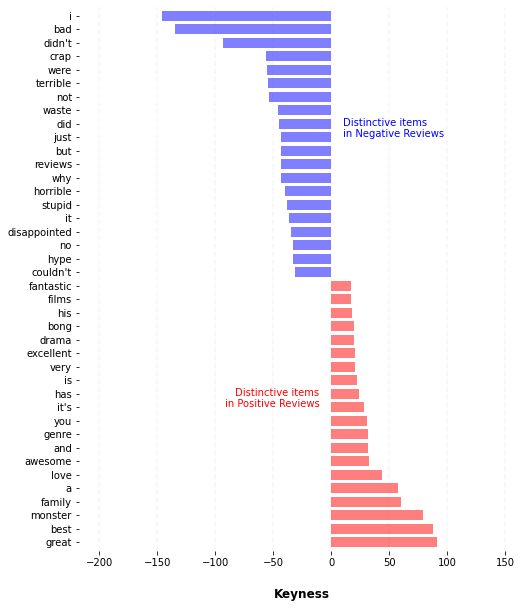

In [36]:
keywords_df = calculate_keyness(pos_freq_host, neg_freq_host, print_table=False, top=-1, keyness_threshold=-100000)
kplot=plot_keyitems(keywords_df, 20, corpusA='Positive Reviews', corpusB='Negative Reviews')

In [37]:
# Another way of displaying the results:
show_keyitems(keywords_df, 30, corpusA='Positive Reviews', corpusB='Negative Reviews')

* Now let's take a look at the bigrams keyness analysis results:

In [38]:
pos_bigrams_host = Counter(get_ngram_tokens(pos_tokens_host,2))
neg_bigrams_host = Counter(get_ngram_tokens(neg_tokens_host,2))

In [39]:
calculate_keyness(pos_bigrams_host, neg_bigrams_host, top=20)

WORD                     Corpus A Freq.Corpus B Freq.Keyness
monster movie            678       81        102.765
the best                 292       19        79.589
one of                   297       41        36.213
a monster                243       36        26.172
a great                  171       23        21.755
and a                    133       17        18.308
monster movies           185       29        17.858
this is                  241       44        16.326
a very                   93        10        16.117
monster film             66        5         16.087
i've seen                87        10        13.880
monster flick            76        8         13.504
good monster             70        7         13.175
in a                     167       29        12.848
is a                     221       43        12.494
the most                 96        13        12.081
the family               95        13        11.753
seen in                  60        6         11.293
ho

In [40]:
calculate_keyness(neg_bigrams_host, pos_bigrams_host, top=20)

WORD                     Corpus A Freq.Corpus B Freq.Keyness
it was                   193       238       76.488
have been                52        25        60.416
movie was                61        45        49.371
the movie                128       165       46.547
a bad                    22        6         34.862
wanted to                20        5         32.859
did not                  21        8         28.216
but the                  65        77        27.723
was just                 22        11        24.867
would have               28        19        24.612
to be                    109       173       24.220
if it                    24        14        24.108
too long                 16        5         23.834
lost in                  16        5         23.834
was the                  40        40        22.363
i didn't                 30        24        22.256
the hype                 16        6         21.689
i had                    38        39        20.455
i w

### Observations

* Super fascinating! Bigrams like `monster movie` and `the best` occur much more frequently in the positive bigram list, and overall there's a lot of buzz about the monster.
* It seems like people are commenting a lot about the monster and using their preconceived notions about what makes a "great monster flick" to rate and review _The Host_ 

Let's try using KWIC concordance analysis to take a deeper dive into some of the words that stand out to me in these lists of reviews:

`Great`:

In [41]:
great_host_kwic = make_kwic('great', pos_tokens_host)

In [42]:
print_kwic(great_host_kwic[:20])

               lot more than cloverfield  great  cinematography on top of
                   taken by the creature  great  stuff korea has delivered
                      delivered a lot of  great  cinema over the past
                          that this it a  great  story with great acting
                      a great story with  great  acting that's delivered in
                        i have ever seen  great  movie guys check it
            while still being incredibly  great  fun some irresponsible scientist
                 well as delivering some  great  monster rampaging and human
                       fights there is a  great  underlying story of a
                      i liked along with  great  characters and an unpredictible
                  much from an otherwise  great  film no hollywood ending
                   think the actors were  great  as well really enjoyable
                  giant monster movie is  great  action great monster and
                   movie is gr

From this small sample, it looks like there are a few themes that `great` is used to describe:
* `Film` or `Cinematography` - Great is used to describe the movie itself, talking about the film action, characters, story, etc.
* `Korea` - This word is also used in context with describing the film industry of South Korea in general! One of the reviews says Korea has delivered "great stuff" and another says "a lot of great cinema". So this means people are recognizing and acknowledging not only the movie, but also the larger film and entertainment industry of Korea.
* `Monster` - This is a big theme in the movie (obviously) and it's intriguing to see how people talk about the monster. It's also very fascinating to see how people write, "great monster" as if they have a certain criteria for what makes a monster great!

With that, let's move onto looking at the next key word, monster.

`Monster`:

In [43]:
monster_neg_kwic = make_kwic('monster', neg_tokens_host)

In [44]:
# Slicing the top part of this list:
print_kwic(monster_neg_kwic[:20])

                      make a really good  monster  though but the movie
                its principal excuse the  monster  grabs the granddaughter and
                      me of stupid asian  monster  movies it was slightly
            all characters defeating the  monster  as a team and
                      pure pure shit bad  monster  bad acting laughable plotline
                    the host because the  monster  is supposed to be
                        "one of the best  monster  movies ever made" i
                 aren't badbut after the  monster  starts hopping on the
                    so disappointed in a  monster  movie very corny g-rated
                       of films a korean  monster  flick - fantastic the
                         until i saw the  monster  aka giant tadpole boring
          special effects recreating the  monster  are pretty good the
                  performances but for a  monster  movie it didn't deliver
             simply didn't decent korean  mon

In [45]:
monster_pos_kwic = make_kwic('monster', pos_tokens_host)

In [46]:
# Slicing the top of this list:
print_kwic(monster_pos_kwic[:20])

                     a fun action packed  monster  drama south korea knocks
                         one of the best  monster  movies ever i hadn't
underneath this ridiculously entertaining  monster  movie but it successfully
         but refreshing excellent korean  monster  movie with some comedy
                         one of the best  monster  movies ever made this
      funnest smartest most exhilarating  monster  horrorcomedy ride i have
                     whatever it is this  monster  movie from korea manages
                        stand out in the  monster  movie genre a lot
                as delivering some great  monster  rampaging and human vs
              cloverfield levels but the  monster  itself it still a
                     long black hair the  monster  wasnt as big as
                           as big as the  monster  in cloverfield thus why
                          so he made his  monster  ginormous on a side
                  ramen noodles the best  monster 

For `monster`, many more of the positive rated reviews mentioned monster. Looking at the two samples above, it looks like main concepts for this word include:
* `Quality` - there's a lot of buzz about what makes a good monster, and whether the CGI was good or not. This is pretty subjective but it's fascinating to see how reviewers describe the creature.
* `Genre` - the other big concept around this word is the genre of a monster, horror movie. I see that there's a comparison made in one of the reviews to the monster in Cloverfield, which is an American monster movie. 

Looking at `translation` among negative reviews of The Host (since it occurred more frequently among those):

In [47]:
translation_kwic = make_kwic('translation', neg_tokens_host)
len(translation_kwic)

20

In [48]:
print_kwic(translation_kwic[:20])

             america with direct english  translation  and it took place
                      poor no matter the  translation  the packaging and commercial
                     for me violation of  translation  my friends and i
                  home for could improve  translation  and remove parts that
                    intended was lost in  translation  but for the most
                        was just lost in  translation  whatever the case there
                    something is lost in  translation  yet another reminder that
                       have been lost in  translation  because it completely falls
                       is because of bad  translation  or just because of
                   funny is the terrible  translation  into english not as
              korean version the english  translation  was absolutely horrific right
                            we got a bad  translation  but i was so
                      charlie in lost in  translation  is a main character
  

What I find most striking is that `translation` is used a lot in the negative review list, either about actually comprehending the story or plot (things were "lost in translation") or about the actual dubbing (translated subtitles too, from Korean to English). I find it fascinating because this points directly to what Director Bong Joon Ho famously said: "Once you overcome the 1-inch tall barrier of subtitles, you will be introduced to so many more amazing films." He was alluding to the American aversion to foreign movies because they have to watch dubbed versions or because they are averse to subtitles/translations, and this is what we start to see in the negative rated reviews. 


One way to quantify this would be to collect words occurring in the context of `translation` in both sets of reviews and then look at their frequency and sentiment.

In [49]:
# get a 8 word window around each instance of `translation` and create lists:

hostneg_trans_colls = Counter(collocates(neg_tokens_host, 'translation', win=[4,4]))
hostpos_trans_colls = Counter(collocates(pos_tokens_host, 'translation', win=[4,4]))

In [50]:
hostneg_trans_colls.most_common(20)

[('in', 13),
 ('lost', 11),
 ('was', 9),
 ('the', 8),
 ('is', 6),
 ('and', 5),
 ('english', 4),
 ('for', 4),
 ('but', 4),
 ('it', 3),
 ('of', 3),
 ('i', 3),
 ('that', 3),
 ('because', 3),
 ('with', 2),
 ('just', 2),
 ('another', 2),
 ('bad', 2),
 ('a', 2),
 ('america', 1)]

In [51]:
hostpos_trans_colls.most_common(20)

[('lost', 5),
 ('in', 5),
 ('are', 4),
 ('though', 3),
 ('and', 3),
 ('the', 3),
 ('there', 2),
 ('horrible', 2),
 ('a', 1),
 ('few', 1),
 ('moments', 1),
 ('an', 1),
 ('amazing', 1),
 ('certainly', 1),
 ('not', 1),
 ('some', 1),
 ('differences', 1),
 ('difficulties', 1),
 ('with', 1),
 ('than', 1)]

In [52]:
sid.polarity_scores(' '.join(hostneg_trans_colls.keys()))


{'compound': -0.8503, 'neg': 0.221, 'neu': 0.619, 'pos': 0.16}

In [53]:
sid.polarity_scores(' '.join(hostpos_trans_colls.keys()))


{'compound': 0.8132, 'neg': 0.217, 'neu': 0.484, 'pos': 0.299}

* This makes sense, there's higher compound sentiment scores for words around `translation` among the positive reviews than among the negative reviews.
* Perhaps this connects to American aversion towards subtitles and foreign movies with poor English translations, makes it harder to overcome the language barrier

Let's move onto the other movie:

**Parasite**

In [54]:
pos_tokens_parasite = []
for rev in pos_parasite:
    toks=tokenize(rev['text'], lowercase=True, strip_chars=chars_to_remove)
    pos_tokens_parasite.extend(toks)

In [55]:
print('{} tokens in the positive reviews'.format(len(pos_tokens_parasite)))

144319 tokens in the positive reviews


In [56]:
neg_tokens_parasite = []
for rev in neg_parasite:
    toks=tokenize(rev['text'], lowercase=True, strip_chars=chars_to_remove)
    neg_tokens_parasite.extend(toks)

In [57]:
print('{} tokens in the negative reviews'.format(len(neg_tokens_parasite)))

27480 tokens in the negative reviews


Creating word and bigram frequency lists:

In [58]:
pos_freq_parasite=Counter(pos_tokens_parasite)
neg_freq_parasite=Counter(neg_tokens_parasite)

In [59]:
pos_freq_parasite.most_common(20)

[('the', 8689),
 ('and', 4797),
 ('a', 4186),
 ('of', 3850),
 ('to', 3038),
 ('it', 2622),
 ('is', 2511),
 ('movie', 2246),
 ('i', 2160),
 ('this', 2050),
 ('in', 2009),
 ('that', 1665),
 ('film', 1471),
 ('was', 1237),
 ('with', 1146),
 ('you', 1133),
 ('for', 926),
 ('as', 920),
 ('but', 910),
 ('best', 861)]

In [60]:
neg_freq_parasite.most_common(20)

[('the', 1632),
 ('and', 768),
 ('a', 648),
 ('to', 632),
 ('of', 609),
 ('i', 570),
 ('it', 568),
 ('was', 437),
 ('movie', 399),
 ('this', 391),
 ('is', 369),
 ('in', 328),
 ('but', 287),
 ('not', 281),
 ('that', 278),
 ('for', 233),
 ('film', 185),
 ('with', 175),
 ('as', 155),
 ('have', 152)]

In [61]:
# keyness analysis to compare normalized word frequencies:
calculate_keyness(pos_freq_parasite, neg_freq_parasite, top=50)


WORD                     Corpus A Freq.Corpus B Freq.Keyness
bong                     432       6         109.186
great                    696       36        87.508
parasite                 528       34        52.045
best                     861       78        48.592
joon-ho                  195       5         39.543
must                     186       5         36.872
one                      807       82        34.842
loved                    184       6         32.865
film                     1471      185       31.464
every                    255       14        30.196
year                     262       15        29.667
story                    640       64        28.782
excellent                179       7         28.408
2019                     174       7         27.054
see                      483       44        26.941
a                        4186      648       25.294
will                     337       27        24.035
is                       2511      369       23.018
fi

In [62]:
# Looking at what's more frequently occurring in negative reviews:
calculate_keyness(neg_freq_parasite, pos_freq_parasite, top=50)


WORD                     Corpus A Freq.Corpus B Freq.Keyness
was                      437       1237      110.875
not                      281       672       108.446
boring                   39        11        94.107
worst                    32        5         89.740
waste                    31        7         79.771
violent                  38        17        77.203
overrated                31        9         74.122
violence                 51        44        71.109
bad                      52        49        67.773
no                       119       241       63.343
awful                    23        5         59.779
ridiculous               22        5         56.514
don't                    86        157       54.164
but                      287       910       50.650
weird                    29        18        50.024
critics                  25        13        47.351
didn't                   55        80        47.010
i                        570       2160      45.005
t

The words that stand out to me the most from the positive tokens are:
`bong`, `great` (which we saw in the previous movie too), `best`, `excellent`, and `korean`. 

For negative tokens:
`boring`, `waste`, `worst`, and `overrated`.

Let's do the same thing as above for displaying these results:

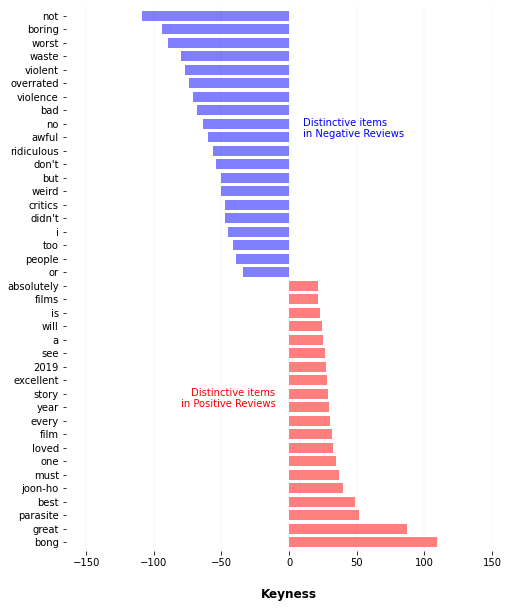

In [63]:
ps_keywords_df = calculate_keyness(pos_freq_parasite, neg_freq_parasite, print_table=False, top=-1, keyness_threshold=-100000)
kplot=plot_keyitems(ps_keywords_df, 20, corpusA='Positive Reviews', corpusB='Negative Reviews')

In [64]:
show_keyitems(ps_keywords_df, 30, corpusA='Positive Reviews', corpusB='Negative Reviews')

Now let's explore the bigram frequency lists for positive and negative reviews, and then go into the same type of keyness analysis:

In [65]:
pos_bigrams_parasite = Counter(get_ngram_tokens(pos_tokens_parasite,2))
neg_bigrams_parasite = Counter(get_ngram_tokens(neg_tokens_parasite,2))

In [66]:
calculate_keyness(pos_bigrams_parasite, neg_bigrams_parasite, top=50)

WORD                     Corpus A Freq.Corpus B Freq.Keyness
the best                 486       7         121.610
one of                   435       16        72.019
parasite is              207       5         43.134
of the                   1335      170       27.064
is a                     419       38        23.590
the year                 163       9         19.187
it's a                   107       6         12.391
movie of                 139       10        11.771
in a                     268       29        9.725
it is                    305       36        8.347
the kim                  78        5         7.732
a little                 82        6         6.771


In [67]:
calculate_keyness(neg_bigrams_parasite,pos_bigrams_parasite, top=50)

WORD                     Corpus A Freq.Corpus B Freq.Keyness
i don't                  43        49        47.562
would have               19        13        30.952
it was                   113       313       30.472
but the                  37        57        29.480
have been                29        37        28.682
i didn't                 26        32        26.682
could have               19        18        24.659
but not                  21        25        22.275
good but                 14        11        20.859
was just                 15        13        20.845
first half               17        18        20.101
any of                   13        10        19.649
the point                14        12        19.614
the hype                 23        34        19.282
did not                  28        49        18.779
was good                 14        13        18.460
of time                  12        9         18.445
too long                 13        11        18.385
the

Hm, I think it's more worthwhile and more intriguing to focus on words instead of bigrams. Let's try carrying out KWIC concordance analysis on some of the words I'm interested in: `bong`, `best`, `korean`, and `boring`.

1) `bong`:

In [68]:
bong_kwic = make_kwic('bong', pos_tokens_parasite)
print_kwic(bong_kwic[:20])

                    of a mirror director  bong  joon-ho moves on to
                          too is made by  bong  joon-ho i had watched
                   popularity it got and  bong  joon-ho shall be remembered
                      be one of director  bong  joon-ho's many timeless masterpieces
                     for yourself led by  bong  joon ho’s powerful direction
                     sides fun and tense  bong  joon-ho once again proves
                 myself i understood why  bong  joon-ho is distinguished by
                     canon but this time  bong  joon-ho presents us with
                         top of all this  bong  joon-ho shows us one
                     it amuses and moves  bong  again provided great entertainment
                    like this movie 1010  bong  joon-ho at his best
                  study of class warfare  bong  joon-ho cements his position
                  "parasite" is a korean  bong  joon-ho to that extent
          soundtrack setting stor

It's quite fascinating to see that Director Bong Joon Ho's name appears much more in the reviews for _Parasite_ than _The Host_ and I think it's probably due to the fact that it's during a more contemporary time in the 21st century, the film won 4 Oscars and was an international success, and he had previously gotten more recognized throughout the 2010's with other notable movies such as "Snowpiercer" and "Okja". 

This public attention to the director's name is significant and we can see this as Director Bong's entrance into mainstream American movie-watching audience's lingo. To even have that knowledge of the Director is surprising to me, I think we don't often stop to look up and research who the directors of every movie we watch are, so this is important!

2) `best`:

In [69]:
best_kwic = make_kwic('best', pos_tokens_parasite)
print_kwic(best_kwic[:20])

                         kino one of the  best  films i've ever seen
                 the acting is fantastic  best  film i've seen in
                     perhaps this is the  best  summary of the tragicomic
                       themes one of the  best  movies i've ever seen
                    and safe daily lives  best  film of 2019 for
                was great definitely the  best  movie of 2019 it
                  a phenomenal movie was  best  i've seen in a
                     bong joon-ho at his  best  parasite is a masterpiece
                         is the only and  best  way to watch it
                   of the 21st century's  best  working directors and possibly
                         is not only the  best  film of 2019 not
                         only one of the  best  films of the decade
                   well deserving of its  best  picture 🏆 your review
                   the academy award for  best  picture this film is
                         and turns - wo

We see mentions of `best film`, and also `best picture` which is one of the Oscars that _Parasite_ won. There's also lots of superlatives here, like `best film of 2019` and `best movie watching experience`.

3) `korean`:

In [70]:
korean_kwic = make_kwic('korean', pos_tokens_parasite)
print_kwic(korean_kwic[:20])

                       i'm not much into  korean  entertainment the only korean
           korean entertainment the only  korean  entertainment i have ever
                            i had seen a  korean  film before was the
                       this is the first  korean  film that i watched
         highly recommend parasitic poor  korean  family infest a very
         sensational achievements of the  korean  this should be a
                   characters are a poor  korean  family parents and two
                          look on a poor  korean  town which in my
                      work by the famous  korean  director feng junhao this
                     this is another few  korean  movies that i want
                            good it is a  korean  language film about a
                      of "parasite" is a  korean  bong joon-ho to that
                 films of our generation  korean  film just keeps getting
                      better one i guess  korean  culture is whe

Again, there's more attention to this being a great KOREAN film and talking about the Korean entertainment industry. 

Let's take a look at `korean` among positive reviews for both movies; sampling, sorting and grouping to discover patterns:

In [71]:
# get a 16 word window around each instance of `korean` and create lists:

host_korean_colls = Counter(collocates(pos_tokens_host, 'korean', win=[8,8]))
ps_korean_colls = Counter(collocates(pos_tokens_parasite, 'korean', win=[8,8]))

In [72]:
host_korean_colls.most_common(20)

[('the', 305),
 ('a', 253),
 ('and', 190),
 ('movie', 175),
 ('of', 171),
 ('monster', 133),
 ('it', 131),
 ('to', 120),
 ('this', 112),
 ('in', 111),
 ('i', 111),
 ('is', 107),
 ('film', 81),
 ('with', 76),
 ('that', 76),
 ("it's", 65),
 ('but', 50),
 ('good', 50),
 ('great', 48),
 ('you', 45)]

In [73]:
ps_korean_colls.most_common(20)

[('the', 159),
 ('a', 144),
 ('and', 104),
 ('of', 90),
 ('is', 75),
 ('to', 69),
 ('film', 65),
 ('it', 61),
 ('i', 59),
 ('this', 56),
 ('movie', 54),
 ('in', 51),
 ('that', 49),
 ('south', 47),
 ('as', 33),
 ('with', 31),
 ('not', 27),
 ('was', 27),
 ('but', 27),
 ('parasite', 25)]

Looking at KWIC concordances:

In [74]:
korean_kwic_host = make_kwic('korean', pos_tokens_host)
len(korean_kwic_host)

430

In [75]:
korean_kwic_host_s1 = random.sample(korean_kwic_host, 50)

In [76]:
print_kwic(sort_kwic(korean_kwic_host_s1, 'R1'))

                        some of the best  korean  actors i've seen pretty
                       what you get with  korean  and many other asianoriental
                 wish i fully understood  korean  and the culture because
                 and manipulation of the  korean  authorities pandering to their
                   a bit strange typical  korean  but a enjoyable slice
                   like monster only the  korean  can put all that
                   politics i love south  korean  cinema this is an
               more taditional values of  korean  cinema and the same
                   you are interested in  korean  cinema i would of
                      movie of a monster  korean  cinema has come a
                    in it's native south  korean  dialogue with subtitles the
                 this one is exceptional  korean  director bong joon-ho tells
                   to order the official  korean  dvd of the film
         surprisingly moving portrait of  korean  family 

In [77]:
korean_kwic_ps = make_kwic('korean', pos_tokens_parasite)
len(korean_kwic_ps)

226

In [78]:
korean_kwic_ps_s1 = random.sample(korean_kwic_ps, 50)

In [79]:
print_kwic(sort_kwic(korean_kwic_ps_s1, 'L1'))

                           only one of a  korean  viewer could catch as
                   more disturbing for a  korean  flick in this genre
                     quick parasite is a  korean  film with a tightly
                 and learning more about  korean  culture did not like
                      be star in america  korean  film master director kfilm
                           40 you may be  korean  russian or belgian none
                         one of the best  korean  movie in recent times
               your everyday normie best  korean  film ever stunning locations
                         one of the best  korean  movies i've ever seen
             well masterfully crafted by  korean  film director bong joon
          amazing and original excellent  korean  cast and director what
                       this is the first  korean  film that i watched
                    movie a typical good  korean  movie could be a
               a director especially his  korean  movies no

And then to the extent we can trust VADER (but could use NRC or TextBlob) you could get the sentiment score for these collocates:

In [80]:
sid.polarity_scores(' '.join(host_korean_colls.keys()))

{'compound': 0.9997, 'neg': 0.171, 'neu': 0.572, 'pos': 0.257}

In [81]:
sid.polarity_scores(' '.join(ps_korean_colls.keys()))

{'compound': 0.9996, 'neg': 0.153, 'neu': 0.566, 'pos': 0.281}

* So more positive words around KOREAN in positive reviews... maybe not that surprising?
* Let's look at another word:

4) `boring`

In [82]:
boring_kwic = make_kwic('boring', neg_tokens_parasite)
print_kwic(boring_kwic[:20])

                     itself is also very  boring  i've just moved to
            worth it overhyped overblown  boring  and somehow people think
                        won't say it was  boring  but it was uninteresting
      minutes was completely predictable  boring  getting the driver and
                     from that basic and  boring  i don't see what
                 awards movie was really  boring  i can't believe it
                      the film and story  boring  without direction lost in
                      kind of happen not  boring  but not a good
                     4hrs anyways such a  boring  boring movie i didn't
                   anyways such a boring  boring  movie i didn't like
                         try it's like a  boring  movie but for some
                      movie was awful so  boring  and not interesting at
               all then after completely  boring  the audience the finish
                     dumb what a stinker  boring  engaging interesting ma

What I want to take away from all of this keyness, frequency, and concordance analysis is that there are distinct words used between positive and negative reviews of either movie. I want to especially highlight `monster`, `korean`, `bong`, `boring`, and `translation`. Some of these results, such as the concordance analysis for words appearing around "korean," would be worth mentioning in my data story.

Now that we've looked over the user reviews, divided them into positive and negative rated reviews, and took a deep dive into the context and keyness analysis, we've hit the end of this notebook. To move onto parts 3-5 of my analysis, let's go to `analysis_user_tomatoes2` the next notebook in my folder! In that pt. 2/2 notebook, I want to quantify my analysis further. I will apply sentiment analysis by using different tools/lexicons that try to capture the valence of emotions used throughout the reviews. 